# Discrete Elastic Shells: Simple Example with Four Nodes
Copyright M. Khalid Jawed (khalidjm@seas.ucla.edu). License: CC BY-NC
You should use this code at your own risk.

#Load Libraries

In [65]:
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt

#Miscellaneous Functions: signedAngle, rotateAxisAngle, parallel_transport, crossMat

In [66]:
def signedAngle(u = None,v = None,n = None):
    # This function calculates the signed angle between two vectors, "u" and "v",
    # using an optional axis vector "n" to determine the direction of the angle.
    #
    # Parameters:
    #   u: numpy array-like, shape (3,), the first vector.
    #   v: numpy array-like, shape (3,), the second vector.
    #   n: numpy array-like, shape (3,), the axis vector that defines the plane
    #      in which the angle is measured. It determines the sign of the angle.
    #
    # Returns:
    #   angle: float, the signed angle (in radians) from vector "u" to vector "v".
    #          The angle is positive if the rotation from "u" to "v" follows
    #          the right-hand rule with respect to the axis "n", and negative otherwise.
    #
    # The function works by:
    # 1. Computing the cross product "w" of "u" and "v" to find the vector orthogonal
    #    to both "u" and "v".
    # 2. Calculating the angle between "u" and "v" using the arctan2 function, which
    #    returns the angle based on the norm of "w" (magnitude of the cross product)
    #    and the dot product of "u" and "v".
    # 3. Using the dot product of "n" and "w" to determine the sign of the angle.
    #    If this dot product is negative, the angle is adjusted to be negative.
    #
    # Example:
    #   signedAngle(np.array([1, 0, 0]), np.array([0, 1, 0]), np.array([0, 0, 1]))
    #   This would return a positive angle (π/2 radians), as the rotation
    #   from the x-axis to the y-axis is counterclockwise when viewed along the z-axis.
    w = np.cross(u,v)
    angle = np.arctan2( np.linalg.norm(w), np.dot(u,v) )
    if (np.dot(n,w) < 0):
        angle = - angle

    return angle

In [67]:
def mmt(matrix):
    return matrix + matrix.T

# Hinge angle, its gradient, and Hessian

In [68]:
#          x2
#          /\
#         /  \
#      e1/    \e3
#       /  t0  \
#      /        \
#     /    e0    \
#   x0------------x1
#     \          /
#      \   t1   /
#       \      /
#      e2\    /e4
#         \  /
#          \/
#          x3
#
#  Edge orientation: e0,e1,e2 point away from x0
#                       e3,e4 point away from x1

In [69]:
def getTheta(x0, x1 = None, x2 = None, x3 = None):

    if np.size(x0) == 12:  # Allow another type of input where x0 contains all the info
      x1 = x0[3:6]
      x2 = x0[6:9]
      x3 = x0[9:12]
      x0 = x0[0:3]

    m_e0 = x1 - x0
    m_e1 = x2 - x0
    m_e2 = x3 - x0

    n0 = np.cross(m_e0, m_e1)
    n1 = np.cross(m_e2, m_e0)

    # Calculate the signed angle using the provided function
    theta = signedAngle(n0, n1, m_e0)

    return theta

In [70]:
# In the original code, there are probaly TWO sign errors in the expressions for m_h3 and m_h4.
# [Original code: % https://github.com/shift09/plates-shells/blob/master/src/bending.cpp]
# I indicated those two corrections by writing the word "CORRECTION" next
# to them.

def gradTheta(x0, x1 = None, x2 = None, x3 = None):

    if np.size(x0) == 12:  # Allow another type of input where x0 contains all the info
      x1 = x0[3:6]
      x2 = x0[6:9]
      x3 = x0[9:12]
      x0 = x0[0:3]

    m_e0 = x1 - x0
    m_e1 = x2 - x0
    m_e2 = x3 - x0
    m_e3 = x2 - x1
    m_e4 = x3 - x1

    m_cosA1 = np.dot(m_e0, m_e1) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e1))
    m_cosA2 = np.dot(m_e0, m_e2) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e2))
    m_cosA3 = -np.dot(m_e0, m_e3) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e3))
    m_cosA4 = -np.dot(m_e0, m_e4) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e4))

    m_sinA1 = np.linalg.norm(np.cross(m_e0, m_e1)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e1))
    m_sinA2 = np.linalg.norm(np.cross(m_e0, m_e2)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e2))
    m_sinA3 = -np.linalg.norm(np.cross(m_e0, m_e3)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e3))
    m_sinA4 = -np.linalg.norm(np.cross(m_e0, m_e4)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e4))

    m_nn1 = np.cross(m_e0, m_e3)
    m_nn1 = m_nn1 / np.linalg.norm(m_nn1)
    m_nn2 = -np.cross(m_e0, m_e4)
    m_nn2 = m_nn2 / np.linalg.norm(m_nn2)

    m_h1 = np.linalg.norm(m_e0) * m_sinA1
    m_h2 = np.linalg.norm(m_e0) * m_sinA2
    m_h3 = -np.linalg.norm(m_e0) * m_sinA3  # CORRECTION
    m_h4 = -np.linalg.norm(m_e0) * m_sinA4  # CORRECTION
    m_h01 = np.linalg.norm(m_e1) * m_sinA1
    m_h02 = np.linalg.norm(m_e2) * m_sinA2

    # Initialize the gradient
    gradTheta = np.zeros(12)

    gradTheta[0:3] = m_cosA3 * m_nn1 / m_h3 + m_cosA4 * m_nn2 / m_h4
    gradTheta[3:6] = m_cosA1 * m_nn1 / m_h1 + m_cosA2 * m_nn2 / m_h2
    gradTheta[6:9] = -m_nn1 / m_h01
    gradTheta[9:12] = -m_nn2 / m_h02

    return gradTheta

In [71]:
def hessTheta(x0, x1 = None, x2 = None, x3 = None):

    if np.size(x0) == 12:  # Allow another type of input where x0 contains all the info
      x1 = x0[3:6]
      x2 = x0[6:9]
      x3 = x0[9:12]
      x0 = x0[0:3]

    m_e0 = x1 - x0
    m_e1 = x2 - x0
    m_e2 = x3 - x0
    m_e3 = x2 - x1
    m_e4 = x3 - x1

    m_cosA1 = np.dot(m_e0, m_e1) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e1))
    m_cosA2 = np.dot(m_e0, m_e2) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e2))
    m_cosA3 = -np.dot(m_e0, m_e3) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e3))
    m_cosA4 = -np.dot(m_e0, m_e4) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e4))

    m_sinA1 = np.linalg.norm(np.cross(m_e0, m_e1)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e1))
    m_sinA2 = np.linalg.norm(np.cross(m_e0, m_e2)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e2))
    m_sinA3 = -np.linalg.norm(np.cross(m_e0, m_e3)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e3))
    m_sinA4 = -np.linalg.norm(np.cross(m_e0, m_e4)) / (np.linalg.norm(m_e0) * np.linalg.norm(m_e4))

    m_nn1 = np.cross(m_e0, m_e3)
    m_nn1 /= np.linalg.norm(m_nn1)
    m_nn2 = -np.cross(m_e0, m_e4)
    m_nn2 /= np.linalg.norm(m_nn2)

    m_h1 = np.linalg.norm(m_e0) * m_sinA1
    m_h2 = np.linalg.norm(m_e0) * m_sinA2
    m_h3 = -np.linalg.norm(m_e0) * m_sinA3
    m_h4 = -np.linalg.norm(m_e0) * m_sinA4
    m_h01 = np.linalg.norm(m_e1) * m_sinA1
    m_h02 = np.linalg.norm(m_e2) * m_sinA2

    # Gradient of Theta (as an intermediate step)
    grad_theta = np.zeros((12, 1))
    grad_theta[0:3] = (m_cosA3 * m_nn1 / m_h3 + m_cosA4 * m_nn2 / m_h4).reshape(-1, 1)
    grad_theta[3:6] = (m_cosA1 * m_nn1 / m_h1 + m_cosA2 * m_nn2 / m_h2).reshape(-1, 1)
    grad_theta[6:9] = (-m_nn1 / m_h01).reshape(-1, 1)
    grad_theta[9:12] = (-m_nn2 / m_h02).reshape(-1, 1)

    # Intermediate matrices for Hessian
    m_m1 = np.cross(m_nn1, m_e1) / np.linalg.norm(m_e1)
    m_m2 = -np.cross(m_nn2, m_e2) / np.linalg.norm(m_e2)
    m_m3 = -np.cross(m_nn1, m_e3) / np.linalg.norm(m_e3)
    m_m4 = np.cross(m_nn2, m_e4) / np.linalg.norm(m_e4)
    m_m01 = -np.cross(m_nn1, m_e0) / np.linalg.norm(m_e0)
    m_m02 = np.cross(m_nn2, m_e0) / np.linalg.norm(m_e0)

    # Hessian matrix components
    M331 = m_cosA3 / (m_h3 ** 2) * np.outer(m_m3, m_nn1)
    M311 = m_cosA3 / (m_h3 * m_h1) * np.outer(m_m1, m_nn1)
    M131 = m_cosA1 / (m_h1 * m_h3) * np.outer(m_m3, m_nn1)
    M3011 = m_cosA3 / (m_h3 * m_h01) * np.outer(m_m01, m_nn1)
    M111 = m_cosA1 / (m_h1 ** 2) * np.outer(m_m1, m_nn1)
    M1011 = m_cosA1 / (m_h1 * m_h01) * np.outer(m_m01, m_nn1)

    M442 = m_cosA4 / (m_h4 ** 2) * np.outer(m_m4, m_nn2)
    M422 = m_cosA4 / (m_h4 * m_h2) * np.outer(m_m2, m_nn2)
    M242 = m_cosA2 / (m_h2 * m_h4) * np.outer(m_m4, m_nn2)
    M4022 = m_cosA4 / (m_h4 * m_h02) * np.outer(m_m02, m_nn2)
    M222 = m_cosA2 / (m_h2 ** 2) * np.outer(m_m2, m_nn2)
    M2022 = m_cosA2 / (m_h2 * m_h02) * np.outer(m_m02, m_nn2)

    B1 = 1 / np.linalg.norm(m_e0) ** 2 * np.outer(m_nn1, m_m01)
    B2 = 1 / np.linalg.norm(m_e0) ** 2 * np.outer(m_nn2, m_m02)

    N13 = 1 / (m_h01 * m_h3) * np.outer(m_nn1, m_m3)
    N24 = 1 / (m_h02 * m_h4) * np.outer(m_nn2, m_m4)
    N11 = 1 / (m_h01 * m_h1) * np.outer(m_nn1, m_m1)
    N22 = 1 / (m_h02 * m_h2) * np.outer(m_nn2, m_m2)
    N101 = 1 / (m_h01 ** 2) * np.outer(m_nn1, m_m01)
    N202 = 1 / (m_h02 ** 2) * np.outer(m_nn2, m_m02)

    # Initialize Hessian of Theta
    hess_theta = np.zeros((12, 12))

    hess_theta[0:3, 0:3] = mmt(M331) - B1 + mmt(M442) - B2
    hess_theta[0:3, 3:6] = M311 + M131.T + B1 + M422 + M242.T + B2
    hess_theta[0:3, 6:9] = M3011 - N13
    hess_theta[0:3, 9:12] = M4022 - N24
    hess_theta[3:6, 3:6] = mmt(M111) - B1 + mmt(M222) - B2
    hess_theta[3:6, 6:9] = M1011 - N11
    hess_theta[3:6, 9:12] = M2022 - N22
    hess_theta[6:9, 6:9] = -mmt(N101)
    hess_theta[9:12, 9:12] = -mmt(N202)

    # Make the Hessian symmetric
    hess_theta[3:6, 0:3] = hess_theta[0:3, 3:6].T
    hess_theta[6:9, 0:3] = hess_theta[0:3, 6:9].T
    hess_theta[9:12, 0:3] = hess_theta[0:3, 9:12].T
    hess_theta[6:9, 3:6] = hess_theta[3:6, 6:9].T
    hess_theta[9:12, 3:6] = hess_theta[3:6, 9:12].T

    return hess_theta


# Stretching energy for a shell, it's gradient, and Hessian

In [72]:
def gradEs_hessEs(node0 = None,node1 = None,l_k = None,EA = None):

# Inputs:
# node0: 1x3 vector - position of the first node
# node1: 1x3 vector - position of the last node

# l_k: reference length (undeformed) of the edge
# EA: scalar - stretching stiffness - Young's modulus times area

# Outputs:
# dF: 6x1  vector - gradient of the stretching energy between node0 and node 1.
# dJ: 6x6 vector - hessian of the stretching energy between node0 and node 1.

    ## Gradient of Es
    edge = node1 - node0

    edgeLen = np.linalg.norm(edge)
    tangent = edge / edgeLen
    epsX = edgeLen / l_k - 1
    dF_unit = EA * tangent * epsX
    dF = np.zeros((6))
    dF[0:3] = - dF_unit
    dF[3:6] = dF_unit

    ## Hessian of Es
    Id3 = np.eye(3)
    M = EA * ((1 / l_k - 1 / edgeLen) * Id3 + 1 / edgeLen * ( np.outer( edge, edge ) ) / edgeLen ** 2)

    dJ = np.zeros((6,6))
    dJ[0:3,0:3] = M
    dJ[3:6,3:6] = M
    dJ[0:3,3:6] = - M
    dJ[3:6,0:3] = - M
    return dF,dJ

# Bending energy for a shell, it's gradient, and Hessian

In [73]:
def getEb_Shell(x0, x1=None, x2=None, x3=None, theta_bar=0, kb=1.0):
    """
    Compute the bending energy for a shell.

    Returns:
    E (scalar): Bending energy.
    """
    # Allow another type of input where x0 contains all the information
    if np.size(x0) == 12:
        x1 = x0[3:6]
        x2 = x0[6:9]
        x3 = x0[9:12]
        x0 = x0[:3]

    # Compute theta, gradient, and Hessian
    theta = getTheta(x0, x1, x2, x3)  # Replace with your getTheta function in Python
    grad = gradTheta(x0, x1, x2, x3)  # Replace with your gradTheta function in Python

    # E = 0.5 * kb * (theta-thetaBar)^2
    E = 0.5 * kb * (theta - theta_bar) ** 2

    return E

In [74]:
def gradEb_hessEb_Shell(x0, x1=None, x2=None, x3=None, theta_bar=0, kb=1.0):
    """
    Compute the gradient and Hessian of the bending energy for a shell.

    Parameters:
    x0 (array): Can either be a 3-element array (single point) or a 12-element array.
    x1, x2, x3 (arrays): Optional, 3-element arrays specifying points.
    theta_bar (float): Reference angle.
    kb (float): Bending stiffness.

    Returns:
    dF (array): Gradient of the bending energy.
    dJ (array): Hessian of the bending energy.
    """
    # Allow another type of input where x0 contains all the information
    if np.size(x0) == 12:
        x1 = x0[3:6]
        x2 = x0[6:9]
        x3 = x0[9:12]
        x0 = x0[:3]

    # Compute theta, gradient, and Hessian
    theta = getTheta(x0, x1, x2, x3)  # Replace with your getTheta function in Python
    grad = gradTheta(x0, x1, x2, x3)  # Replace with your gradTheta function in Python

    # E = 0.5 * kb * (theta-thetaBar)^2
    # F = dE/dx = 2 * (theta-thetaBar) * gradTheta
    dF = 0.5 * kb * (2 * (theta - theta_bar) * grad)

    # E = 0.5 * kb * (theta-thetaBar)^2
    # F = 0.5 * kb * (2 (theta-thetaBar) d theta/dx)
    # J = dF/dx = 0.5 * kb * [ 2 (d theta / dx) transpose(d theta/dx) +
    #       2 (theta-thetaBar) (d^2 theta/ dx^2 ) ]
    hess = hessTheta(x0, x1, x2, x3)  # Replace with your hessTheta function in Python
    dJ = 0.5 * kb * (2 * np.outer(grad, grad) + 2 * (theta - theta_bar) * hess)

    return dF, dJ

#Plot the shell

In [75]:
# Function to set equal aspect ratio for 3D plots
def set_axes_equal(ax):
    """
    Set equal aspect ratio for a 3D plot in Matplotlib.
    This function adjusts the limits of the plot to make sure
    that the scale is equal along all three axes.
    """
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])

    max_range = max(x_range, y_range, z_range)

    x_middle = np.mean(x_limits)
    y_middle = np.mean(y_limits)
    z_middle = np.mean(z_limits)

    ax.set_xlim3d([x_middle - max_range / 2, x_middle + max_range / 2])
    ax.set_ylim3d([y_middle - max_range / 2, y_middle + max_range / 2])
    ax.set_zlim3d([z_middle - max_range / 2, z_middle + max_range / 2])

In [76]:
def plotShell(x0, ctime):

  x1 = x0[3:6]
  x2 = x0[6:9]
  x3 = x0[9:12]
  x0 = x0[0:3]

  fig = plt.figure(1)
  clear_output()
  plt.clf()  # Clear the figure
  ax = fig.add_subplot(111, projection='3d')

  # Plot nodes
  X = np.array([x0[0], x1[0], x2[0], x0[0], x3[0], x1[0]])
  Y = np.array([x0[1], x1[1], x2[1], x0[1], x3[1], x1[1]])
  Z = np.array([x0[2], x1[2], x2[2], x0[2], x3[2], x1[2]])
  ax.plot3D(X, Y, Z, 'ko-')

  # Plot the first node with a red triangle
  ax.plot3D([X[0]], [Y[0]], [Z[0]], 'r^')

  # Set the title with current time
  ax.set_title(f't={ctime:.2f}')

  # Set axes labels
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z')

  # Set equal scaling and a 3D view
  set_axes_equal(ax)
  plt.draw()  # Force a redraw of the figure

  plt.show()

# Objective function

In [77]:
def objfun(qOld, uOld, freeIndex, dt, tol, massVector, massMatrix,
           ks, refLen, edges,
           kb, thetaBar, hinges,
           Fg, visc):

  qNew = qOld.copy()
  ndof = len(qOld) # Number of DOFs

  iter = 0 # number of iteration
  error = 10 * tol
  # Newton Raphson
  while error > tol:

    # Bending force and jacobian
    Fb = np.zeros( ndof )
    Jb = np.zeros( (ndof,ndof) )
    # Loop over every "bending spring" or "hinge"
    for kHinge in range(hinges.shape[0]):
      node0 = hinges[kHinge, 0]
      node1 = hinges[kHinge, 1]
      node2 = hinges[kHinge, 2]
      node3 = hinges[kHinge, 3]
      x0 = qNew[ 3*node0: 3*node0 + 3]
      x1 = qNew[ 3*node1: 3*node1 + 3]
      x2 = qNew[ 3*node2: 3*node2 + 3]
      x3 = qNew[ 3*node3: 3*node3 + 3]
      ind = [3*node0, 3*node0 + 1, 3*node0 + 2,
             3*node1, 3*node1 + 1, 3*node1 + 2,
             3*node2, 3*node2 + 1, 3*node2 + 2,
             3*node3, 3*node3 + 1, 3*node3 + 2]
      dF, dJ = gradEb_hessEb_Shell(x0, x1, x2, x3, 0, kb)
      Fb[ind] -= dF
      Jb[np.ix_(ind,ind)] -= dJ

    # Stretching force and jacobian
    Fs = np.zeros( ndof )
    Js = np.zeros( (ndof,ndof) )
    for kEdge in range(edges.shape[0]):
      node0 = edges[kEdge, 0]
      node1 = edges[kEdge, 1]
      x0 = qNew[ 3*node0: 3*node0 + 3]
      x1 = qNew[ 3*node1: 3*node1 + 3]
      ind = [3*node0, 3*node0 + 1, 3*node0 + 2,
             3*node1, 3*node1 + 1, 3*node1 + 2]
      dF, dJ = gradEs_hessEs(x0, x1, refLen[kEdge], ks[kEdge])
      Fs[ind] -= dF
      Js[np.ix_(ind,ind)] -= dJ

    # Viscous force
    Fv = - visc * (qNew - qOld) / dt
    Jv = - visc / dt * np.eye(ndof)

    Forces = Fb + Fs + Fg + Fv # Sum of forces
    JForces = Jb + Js + Jv # Sum of Jacobians

    # Set up my equations of motion and calculating its residual (=0)
    f = massVector / dt * ( (qNew - qOld)/dt - uOld) - Forces # Residual of EOM
    J = massMatrix / dt ** 2 - JForces

    # Extract the free part of the f and J arrays
    f_free = f[freeIndex]
    J_free = J[np.ix_(freeIndex, freeIndex)]
    # Correction
    dq_free = np.linalg.solve(J_free, f_free)

    # Update my guess for position
    qNew[freeIndex] -= dq_free

    # Calculate error
    error = np.sum( np.abs(f_free))

    iter += 1

    print('Iter = ', iter, ' error=', error)

  uNew = (qNew - qOld) / dt
  return qNew, uNew

#Main Discrete Shells

**DOFs and Nodes**

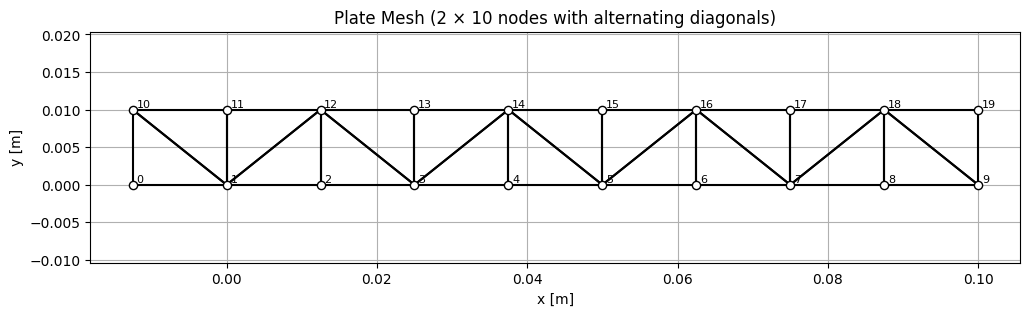

In [78]:
# Material + Plate Geometry
Y  = 1e7
rho = 1000

# Geometry
l_free = 0.10
w      = 0.01
h      = 0.002

# Explicit X-positions Figure
xs = np.array([
    -0.0125,
     0.0,
     0.0125,
     0.025,
     0.0375,
     0.05,
     0.0625,
     0.075,
     0.0875,
     0.10
], dtype=float)

# Y-positions
ys = [0.0, 0.01]

# Build node list: bottom row indices 0..9, top row 10..19
X = []
for y in ys:
    for x in xs:
        X.append([x, y, 0.0])   # initial z = 0
X = np.array(X)                 # shape (20, 3)

nv   = X.shape[0]               # 20 nodes
ndof = 3 * nv                   # 60 DOFs
qOld = X.reshape(-1)

visc = 0.0                      # damping (can adjust later)


# === 2: Triangles (alternating diagonals) and mesh plot ===

triangles = []

# bottom: 0..9, top: 10..19
for i in range(9):   # 9 panels between 10 columns
    bL = i
    bR = i + 1
    tL = i + 10
    tR = i + 11

    if i % 2 == 0:
        # even panels: diagonal from bottom-right to top-left (bR–tL)
        triangles.append((bL, bR, tL))
        triangles.append((bR, tR, tL))
    else:
        # odd panels: diagonal from bottom-left to top-right (bL–tR)
        triangles.append((bL, bR, tR))
        triangles.append((bL, tR, tL))

triangles = np.array(triangles, dtype=int)


def plot_mesh_hw5(nodes, elements):
    """Plot HW5 mesh with node numbers, matching the assignment figure."""
    xy = nodes[:, :2]

    plt.figure(figsize=(12, 3))

    # Draw triangle edges
    for tri in elements:
        P = xy[tri]
        for k in range(3):
            x_vals = [P[k, 0], P[(k+1) % 3, 0]]
            y_vals = [P[k, 1], P[(k+1) % 3, 1]]
            plt.plot(x_vals, y_vals, 'k-')

    # draw nodes
    plt.scatter(xy[:, 0], xy[:, 1], s=35, color='white', edgecolors='k', zorder=5)

    # label nodes
    for idx, (xx, yy) in enumerate(xy):
        plt.text(xx + 0.0005, yy + 0.0003, str(idx), fontsize=8)

    plt.title("Plate Mesh (2 × 10 nodes with alternating diagonals)")
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")
    plt.axis('equal')
    plt.grid(True)
    plt.show()

    # Plot the mesh to verify it matches the figure
plot_mesh_hw5(X, triangles)

**Springs: Create edges (stretching) and hinges (bending)**

In [79]:
# === 2: Triangle Connectivity (Correct, no crossing diagonals) ===

triangles = []

# bottom row: 0..9, top row: 10..19
for i in range(9):       # 9 panels
    bL = i
    bR = i + 1
    tL = i + 10
    tR = i + 11

    # Two triangles per rectangle panel
    # Diagonal is (bR, tL), matching a standard consistent orientation
    triangles.append((bL, bR, tL))
    triangles.append((bR, tR, tL))

triangles = np.array(triangles, dtype=int)

# === 3: Extract Edges and Hinges ===

from collections import defaultdict

# ---- Build unique edges ----
edge_dict = {}
edges = []

for tri in triangles:
    face_edges = [(tri[0],tri[1]), (tri[1],tri[2]), (tri[2],tri[0])]
    for i, j in face_edges:
        if i > j: i, j = j, i
        if (i,j) not in edge_dict:
            edge_dict[(i,j)] = len(edges)
            edges.append((i,j))

edges = np.array(edges, dtype=int)

# ---- Find hinges ----
edge_to_tri = defaultdict(list)
for t, tri in enumerate(triangles):
    for i, j in [(tri[0],tri[1]), (tri[1],tri[2]), (tri[2],tri[0])]:
        if i > j: i, j = j, i
        edge_to_tri[(i,j)].append(t)

hinges = []
for (i,j), tris in edge_to_tri.items():
    if len(tris) == 2:
        t1, t2 = tris
        tri1 = triangles[t1]
        tri2 = triangles[t2]
        k = [v for v in tri1 if v not in (i,j)][0]
        l = [v for v in tri2 if v not in (i,j)][0]
        hinges.append((i, j, k, l))

hinges = np.array(hinges, dtype=int)

# 4: Elastic stiffness ===

# Bending stiffness
kb = 2.0 / np.sqrt(3.0) * Y * h**3 / 12.0

refLen = np.zeros(len(edges))
ks     = np.zeros(len(edges))

for e,(i,j) in enumerate(edges):
    xi = qOld[3*i:3*i+3]
    xj = qOld[3*j:3*j+3]
    refLen[e] = np.linalg.norm(xj - xi)
    ks[e] = np.sqrt(3)/2 * Y * h * refLen[e]**2

# Newton tolerance
tol = kb / 0.01 * 1e-3



**Elastic Stiffness**

In [80]:
# === 5: Mass + Gravity ===

# Lumped mass model
V = l_free * w * h
totalM = rho * V
dm = totalM / nv

massVector = np.zeros(ndof)
for n in range(nv):
    massVector[3*n : 3*n+3] = dm

massMatrix = np.diag(massVector)

# Gravity (negative z)
Fg = np.zeros(ndof)
gvec = np.array([0,0,-9.81])
for n in range(nv):
    Fg[3*n:3*n+3] = massVector[3*n:3*n+3] * gvec


# === 6: Rest angles thetaBar ===

thetaBar = np.zeros(len(hinges))

for h_idx,(i,j,k,l) in enumerate(hinges):
    xi = qOld[3*i:3*i+3]
    xj = qOld[3*j:3*j+3]
    xk = qOld[3*k:3*k+3]
    xl = qOld[3*l:3*l+3]
    thetaBar[h_idx] = getTheta(xi, xj, xk, xl)

# === 7: Boundary Conditions ===

fixed_nodes = np.array([0, 1, 10, 11], dtype=int)

fixedIndex = []
for n in fixed_nodes:
    fixedIndex += [3*n, 3*n+1, 3*n+2]
fixedIndex = np.array(fixedIndex)

allIndex  = np.arange(ndof)
freeIndex = np.setdiff1d(allIndex, fixedIndex)

uOld = np.zeros(ndof)

# Tip nodes (right edge, x = 0.10)
tip_nodes  = [9, 19]
tip_dofs_z = [3*9+2, 3*19+2]

z_tip0 = np.mean(qOld[tip_dofs_z])


**Mass Vector and Matrix**

In [81]:
# === 4: Mass matrix and gravity ===

# Beam volume
V      = l_free * w * h
totalM = rho * V
dm     = totalM / nv

massVector = np.zeros(ndof)
for n in range(nv):
    idx = [3*n, 3*n+1, 3*n+2]
    massVector[idx] = dm

massMatrix = np.diag(massVector)

# Gravity force vector
g = np.array([0.0, 0.0, -9.81])
Fg = np.zeros(ndof)
for n in range(nv):
    idx = [3*n, 3*n+1, 3*n+2]
    Fg[idx] = massVector[idx] * g


**External force**

In [82]:
# === External force: gravity in negative z ===

g = np.array([0.0, 0.0, -9.81])   # gravity vector

Fg = np.zeros(ndof)
for c in range(nv):
    ind = [3*c, 3*c + 1, 3*c + 2]
    Fg[ind] = massVector[ind] * g


**Natural curvature**

In [83]:
# === 5: Compute rest angles thetaBar for each hinge ===

thetaBar = np.zeros(len(hinges))

for h_idx, (i, j, k, l) in enumerate(hinges):
    xi = qOld[3*i : 3*i+3]
    xj = qOld[3*j : 3*j+3]
    xk = qOld[3*k : 3*k+3]
    xl = qOld[3*l : 3*l+3]
    thetaBar[h_idx] = getTheta(xi, xj, xk, xl)


**Boundary conditions and Initial Conditions**

In [84]:
# === 7: Boundary Conditions ===

fixed_nodes = np.array([0, 1, 10, 11], dtype=int)

fixedIndex = []
for n in fixed_nodes:
    fixedIndex += [3*n, 3*n+1, 3*n+2]
fixedIndex = np.array(fixedIndex)

allIndex  = np.arange(ndof)
freeIndex = np.setdiff1d(allIndex, fixedIndex)

uOld = np.zeros(ndof)

# Tip nodes (right edge, x = 0.10)
tip_nodes  = [9, 19]
tip_dofs_z = [3*9+2, 3*19+2]

z_tip0 = np.mean(qOld[tip_dofs_z])


**Time stepping loop**

In [85]:
# === 8: Time stepping ===

dt = 1e-3
totalTime = 20.0

hard_break_step = 20000
Nsteps_raw = int(totalTime / dt)
Nsteps = min(Nsteps_raw, hard_break_step)

ctime = 0.0
deltaTip = np.zeros(Nsteps)

for step in range(Nsteps):
    print(f"step {step}, time {ctime:.4f}")

    qNew, uNew = objfun(
        qOld, uOld, freeIndex, dt, tol,
        massVector, massMatrix,
        ks, refLen, edges,
        kb, thetaBar, hinges,
        Fg, visc
    )

    ctime += dt

    qOld = qNew.copy()
    uOld = uNew.copy()

    z_tip = np.mean(qNew[tip_dofs_z])
    deltaTip[step] = z_tip - z_tip0


Streaming output truncated to the last 5000 lines.
step 18312, time 18.3120
Iter =  1  error= 0.003626816697932315
Iter =  2  error= 4.0476838701234774e-08
step 18313, time 18.3130
Iter =  1  error= 0.0033139567041513634
Iter =  2  error= 3.3814235219238034e-08
step 18314, time 18.3140
Iter =  1  error= 0.002999835738466502
Iter =  2  error= 2.772707155276969e-08
step 18315, time 18.3150
Iter =  1  error= 0.0026845866187161257
Iter =  2  error= 2.222492963359471e-08
step 18316, time 18.3160
Iter =  1  error= 0.0023683425945500995
Iter =  2  error= 1.7316202600273548e-08
step 18317, time 18.3170
Iter =  1  error= 0.0020512372894185005
Iter =  2  error= 1.3008374067791236e-08
step 18318, time 18.3180
Iter =  1  error= 0.001733404642420267
Iter =  2  error= 9.307900702492202e-09
step 18319, time 18.3190
Iter =  1  error= 0.0014149788500048127
Iter =  2  error= 6.220236913666668e-09
step 18320, time 18.3200
Iter =  1  error= 0.0010960943075881194
Iter =  2  error= 3.7497808334078e-09
step 

Steady displacement for discrete plate simulation (δ_plate): -0.03483798189574103 meters


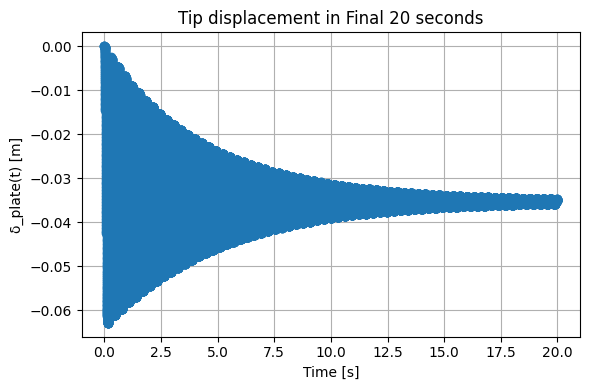

In [86]:
# === 9: Plot last 15 seconds + steady displacement ===

plot_duration = 20.0
steps_to_plot = int(plot_duration / dt)

# Limit in case simulation shorter
if steps_to_plot > len(deltaTip):
    steps_to_plot = len(deltaTip)

# Full time series
t_full = np.arange(len(deltaTip)) * dt

# Extract last window
t_plot = t_full[-steps_to_plot:]
d_plot = deltaTip[-steps_to_plot:]

# ---- Steady displacement (final δ_plate) ----
delta_plate_steady = deltaTip[-1]
print("Steady displacement for discrete plate simulation (δ_plate):", delta_plate_steady, "meters")

# ---- Plot ----
plt.figure(figsize=(6,4))
plt.plot(t_plot, d_plot, 'o-')
plt.xlabel("Time [s]")
plt.ylabel("δ_plate(t) [m]")
plt.title("Tip displacement in Final 20 seconds")
plt.grid(True)
plt.tight_layout()
plt.show()


In [87]:
# === 9: Euler–Bernoulli  ===

A = w * h
I = w * h**3 / 12
q_load = rho * A * 9.81

delta_EB = q_load * l_free**4 / (8 * Y * I)

# steady displacement from simulation
delta_plate_steady = deltaTip[-1]

# normalized difference
normalized_diff = ((delta_EB + delta_plate_steady) / delta_EB) * 100
normalized_diff = round(normalized_diff, 1)

print("δ_plate (steady)  =", -delta_plate_steady)
print("δ_EB (theory)     =",  delta_EB)
print("Normalized diff   =", normalized_diff, "%")


δ_plate (steady)  = 0.03483798189574103
δ_EB (theory)     = 0.03678750000000001
Normalized diff   = 5.3 %
